In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Create timestamp range for one year of hourly data
start_date = datetime(2023, 1, 1, 0, 0)
end_date = datetime(2023, 12, 31, 23, 0)
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Initialize dataframe with timestamps
data = pd.DataFrame({'timestamp': timestamps})

# Create base demand with daily patterns
hourly_pattern = np.array([
    0.85, 0.80, 0.75, 0.70, 0.65, 0.70,  # 00:00 - 05:00
    0.80, 0.95, 1.10, 1.15, 1.10, 1.05,  # 06:00 - 11:00
    1.00, 1.05, 1.10, 1.15, 1.20, 1.25,  # 12:00 - 17:00
    1.30, 1.20, 1.10, 1.00, 0.95, 0.90   # 18:00 - 23:00
])

# Add hourly pattern
data['hour'] = data['timestamp'].dt.hour
data['base_demand'] = data['hour'].apply(lambda x: hourly_pattern[x])

# Add weekly pattern (weekends have lower demand)
data['dayofweek'] = data['timestamp'].dt.dayofweek
data['weekend_factor'] = data['dayofweek'].apply(lambda x: 0.85 if x >= 5 else 1.0)
data['base_demand'] = data['base_demand'] * data['weekend_factor']

# Add monthly seasonal pattern
data['month'] = data['timestamp'].dt.month
monthly_pattern = {
    1: 1.15,  # January - high demand due to winter
    2: 1.10,
    3: 1.00,
    4: 0.90,
    5: 0.85,
    6: 0.95,  # Summer AC usage starts increasing
    7: 1.10,  # Summer peak
    8: 1.15,  # Summer peak
    9: 0.90,
    10: 0.85,
    11: 0.95,
    12: 1.10   # December - holiday season
}
data['monthly_factor'] = data['month'].map(monthly_pattern)
data['base_demand'] = data['base_demand'] * data['monthly_factor']

# Add temperature effect (approximated)
# Create synthetic temperature data
data['temp_base'] = data['timestamp'].dt.dayofyear.apply(
    lambda x: 20 + 15 * np.sin((x - 15) / 365 * 2 * np.pi)  # Peaks in summer
)
data['daily_temp_noise'] = np.random.normal(0, 3, len(data))
data['hourly_temp_noise'] = np.random.normal(0, 1, len(data))
data['temperature'] = data['temp_base'] + data['daily_temp_noise'] + data['hourly_temp_noise']

# Add temperature effect to demand (high demand on very cold and very hot days)
data['temp_factor'] = 1.0 + 0.01 * np.abs(data['temperature'] - 20)
data['base_demand'] = data['base_demand'] * data['temp_factor']

# Add special events (holidays with higher demand)
holidays = [
    '2023-01-01',  # New Year's Day
    '2023-12-25',  # Christmas
    '2023-07-04',  # Independence Day
    '2023-11-23',  # Thanksgiving
]
data['holiday'] = data['timestamp'].dt.strftime('%Y-%m-%d').isin(holidays)
data['holiday_factor'] = data['holiday'].apply(lambda x: 1.2 if x else 1.0)
data['base_demand'] = data['base_demand'] * data['holiday_factor']

# Add some random fluctuations
data['random_factor'] = np.random.normal(1, 0.05, len(data))
data['base_demand'] = data['base_demand'] * data['random_factor']

# Add occasional demand spikes
num_spikes = 20
spike_indices = np.random.choice(len(data), num_spikes, replace=False)
spike_factors = np.random.uniform(1.3, 1.5, num_spikes)
for idx, factor in zip(spike_indices, spike_factors):
    data.loc[idx, 'base_demand'] = data.loc[idx, 'base_demand'] * factor

# Add occasional drops
num_drops = 15
drop_indices = np.random.choice(len(data), num_drops, replace=False)
drop_factors = np.random.uniform(0.6, 0.8, num_drops)
for idx, factor in zip(drop_indices, drop_factors):
    data.loc[idx, 'base_demand'] = data.loc[idx, 'base_demand'] * factor

# Scale demand to realistic values (MW)
base_load = 5000  # Base load in MW
peak_variation = 3000  # Peak variation in MW
data['demand'] = base_load + data['base_demand'] * peak_variation

# Round demand to reasonable precision
data['demand'] = data['demand'].round(2)

# Add some missing values to make the dataset more realistic
missing_indices = np.random.choice(len(data), 50, replace=False)
data.loc[missing_indices, 'demand'] = np.nan

# Interpolate missing values
data['demand'] = data['demand'].interpolate(method='linear')

# Add system outage period (3 days in March)
outage_start = datetime(2023, 3, 15, 0, 0)
outage_end = datetime(2023, 3, 17, 23, 0)
outage_mask = (data['timestamp'] >= outage_start) & (data['timestamp'] <= outage_end)
data.loc[outage_mask, 'demand'] = data.loc[outage_mask, 'demand'] * 0.7

# Create a simple CSV with just timestamp and demand
final_data = data[['timestamp', 'demand']]

# Save to CSV
final_data.to_csv('electricity_demand.csv', index=False)

# Print sample of the data
print(final_data.head(24))

# Print dataset statistics
print("\nDataset Statistics:")
print(f"Time Range: {final_data['timestamp'].min()} to {final_data['timestamp'].max()}")
print(f"Number of Records: {len(final_data)}")
print(f"Demand Min: {final_data['demand'].min():.2f} MW")
print(f"Demand Max: {final_data['demand'].max():.2f} MW")
print(f"Demand Mean: {final_data['demand'].mean():.2f} MW")
print(f"Demand Std: {final_data['demand'].std():.2f} MW")

# Generate the actual CSV content as a string (first 500 rows)
csv_content = final_data.head(500).to_csv(index=False)
print("\nFirst 20 rows of CSV content:")
print('\n'.join(csv_content.split('\n')[:21]))

<ipython-input-1-afa8f9f3654b>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start_date, end=end_date, freq='H')


             timestamp   demand
0  2023-01-01 00:00:00  8042.81
1  2023-01-01 01:00:00  8070.90
2  2023-01-01 02:00:00  7597.30
3  2023-01-01 03:00:00  7714.02
4  2023-01-01 04:00:00  7142.47
5  2023-01-01 05:00:00  7767.75
6  2023-01-01 06:00:00  7869.88
7  2023-01-01 07:00:00  8548.91
8  2023-01-01 08:00:00  9135.87
9  2023-01-01 09:00:00  9165.14
10 2023-01-01 10:00:00  9190.82
11 2023-01-01 11:00:00  8975.47
12 2023-01-01 12:00:00  8587.21
13 2023-01-01 13:00:00  9222.78
14 2023-01-01 14:00:00  8929.03
15 2023-01-01 15:00:00  9314.58
16 2023-01-01 16:00:00  9705.58
17 2023-01-01 17:00:00  9686.63
18 2023-01-01 18:00:00  9920.98
19 2023-01-01 19:00:00  9470.44
20 2023-01-01 20:00:00  9047.78
21 2023-01-01 21:00:00  8513.52
22 2023-01-01 22:00:00  8715.57
23 2023-01-01 23:00:00  8438.12

Dataset Statistics:
Time Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Number of Records: 8760
Demand Min: 4993.69 MW
Demand Max: 11495.01 MW
Demand Mean: 8101.10 MW
Demand Std: 730.56 MW

First 

Epoch 5/50, Loss: 0.121316
Epoch 10/50, Loss: 0.108993
Epoch 15/50, Loss: 0.100494
Epoch 20/50, Loss: 0.101718
Epoch 25/50, Loss: 0.089415
Epoch 30/50, Loss: 0.083468
Epoch 35/50, Loss: 0.073905
Epoch 40/50, Loss: 0.085322
Epoch 45/50, Loss: 0.061350
Epoch 50/50, Loss: 0.053226
Test Loss: 0.171263, MAE: 216.22, RMSE: 301.97


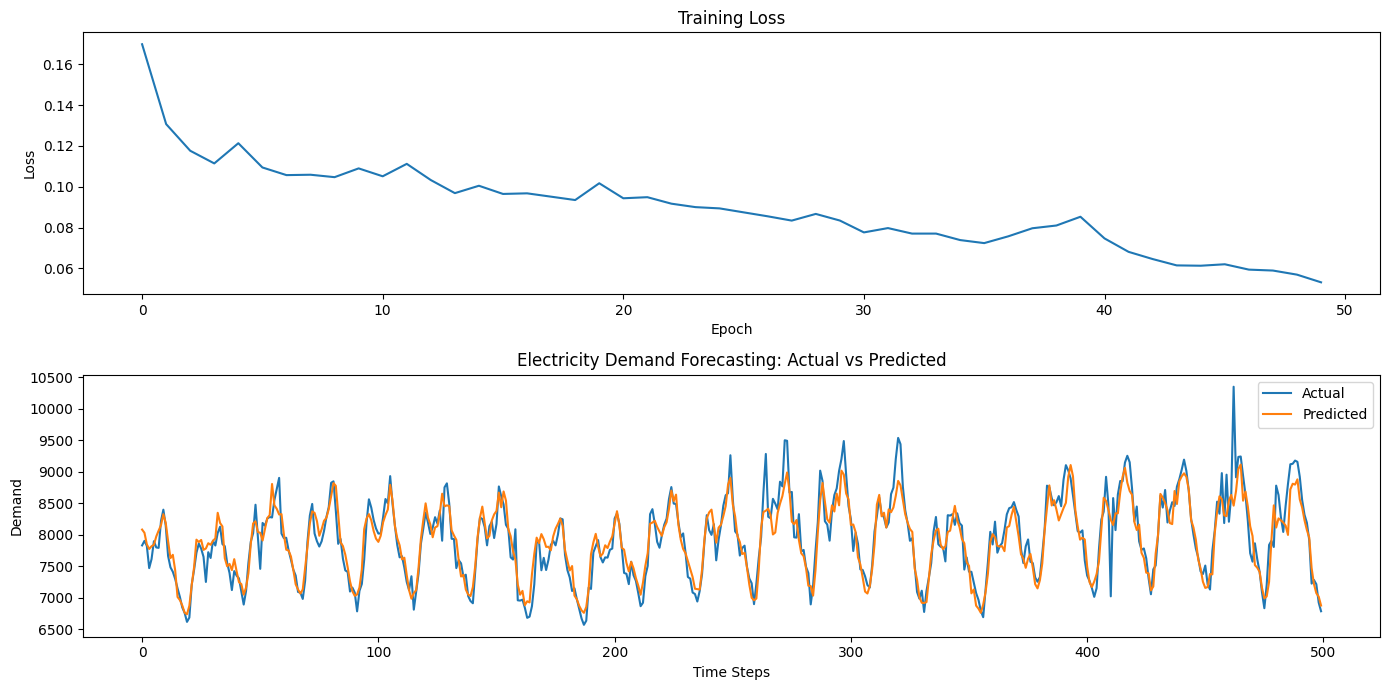

24-hour forecast: [np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124), np.float32(8474.124)]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load and prepare electricity demand data
# Assuming we have hourly electricity demand data
data = pd.read_csv('electricity_demand.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
data = data.sort_index()

# Feature engineering: create lag features and temporal features
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['year'] = df.index.year

    # Create lag features (previous 24 hours, 7 days ago, 1 month ago)
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        df[f'demand_lag_{i}h'] = df['demand'].shift(i)

    df[f'demand_lag_1d'] = df['demand'].shift(24)
    df[f'demand_lag_7d'] = df['demand'].shift(24*7)

    # Rolling statistics
    df['demand_rolling_mean_24h'] = df['demand'].rolling(window=24).mean().shift(1)
    df['demand_rolling_std_24h'] = df['demand'].rolling(window=24).std().shift(1)

    return df

data = create_features(data)
data = data.dropna()

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Define features and target
target_col = 'demand'
feature_cols = [col for col in data.columns if col != target_col]

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(train_data[feature_cols])
y_train = scaler_y.fit_transform(train_data[[target_col]])

X_test = scaler_X.transform(test_data[feature_cols])
y_test = scaler_y.transform(test_data[[target_col]])

# Create PyTorch dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Lag-Llama model
class LagLlamaForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, dropout=0.1):
        super(LagLlamaForecaster, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Transformer layers with RMSNorm (similar to Llama architecture)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=8,
                dim_feedforward=4*hidden_dim,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            )
            for _ in range(num_layers)
        ])

        # Normalization layers (similar to RMSNorm in Llama)
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(num_layers)
        ])

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Apply transformer layers with normalization
        for transformer_layer, norm_layer in zip(self.transformer_layers, self.norm_layers):
            x = norm_layer(transformer_layer(x))

        # Output projection
        output = self.output_projection(x)

        return output

# Initialize model
input_dim = len(feature_cols)  # Number of features
hidden_dim = 128
output_dim = 1  # Predicting a single value (demand)
model = LagLlamaForecaster(input_dim, hidden_dim, output_dim)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        # Update learning rate
        scheduler.step(epoch_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}')

    return train_losses

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            all_preds.append(outputs.numpy())
            all_trues.append(y_batch.numpy())

    test_loss /= len(test_loader)

    all_preds = np.vstack(all_preds)
    all_trues = np.vstack(all_trues)

    # Inverse transform to get actual values
    all_preds = scaler_y.inverse_transform(all_preds)
    all_trues = scaler_y.inverse_transform(all_trues)

    # Calculate metrics
    mae = mean_absolute_error(all_trues, all_preds)
    rmse = np.sqrt(mean_squared_error(all_trues, all_preds))

    return test_loss, mae, rmse, all_preds, all_trues

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer)

# Evaluate the model
test_loss, mae, rmse, predictions, actuals = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# Plot results
plt.figure(figsize=(14, 7))

# Plot training loss
plt.subplot(2, 1, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot predictions vs actuals for a subset of the test data
plt.subplot(2, 1, 2)
subset_size = min(500, len(predictions))
plt.plot(actuals[:subset_size], label='Actual')
plt.plot(predictions[:subset_size], label='Predicted')
plt.title('Electricity Demand Forecasting: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Demand')
plt.legend()

plt.tight_layout()
plt.savefig('lag_llama_results.png')
plt.show()

# Function to make multi-step forecasts
def make_forecast(model, last_data_point, scaler_X, scaler_y, steps=24):
    model.eval()
    forecasts = []
    current_input = last_data_point.copy()

    for step in range(steps):
        # Scale input
        scaled_input = scaler_X.transform([current_input])
        tensor_input = torch.tensor(scaled_input, dtype=torch.float32)

        # Make prediction
        with torch.no_grad():
            scaled_output = model(tensor_input).numpy()

        # Inverse transform
        prediction = scaler_y.inverse_transform(scaled_output)[0, 0]
        forecasts.append(prediction)

        # Update input for next step (assuming we have the proper structure to update lags)
        # This is simplified and would need to be adapted to your actual feature structure
        current_input = update_features_for_next_step(current_input, prediction)

    return forecasts

def update_features_for_next_step(current_features, new_prediction):
    # This function would update the features for the next time step
    # including shifting lag values and updating temporal features
    # This is a placeholder - implementation depends on your feature structure
    updated_features = current_features.copy()
    # Update lag features
    # Update temporal features
    return updated_features

# Make a 24-hour forecast using the last data point
last_data_point = X_test[-1]
forecasts = make_forecast(model, last_data_point, scaler_X, scaler_y, steps=24)
print("24-hour forecast:", forecasts)